Analyzing logs for DQN in './dqn/logs'...
--> Analysis complete for DQN.

Analyzing logs for PPO in './ppo/logs'...
--> Analysis complete for PPO.

--- Performance Metrics Summary ---
          Total Episodes Total Timesteps Mean Reward (All) Std Dev (All) Max Reward Mean Reward (Last 100) Std Dev (Last 100)
Algorithm                                                                                                                    
DQN               11,076      40,761,596             80.46        106.35     428.00                 320.23              88.68
PPO                8,977      40,610,211            106.44        108.47     428.00                 285.94              92.30


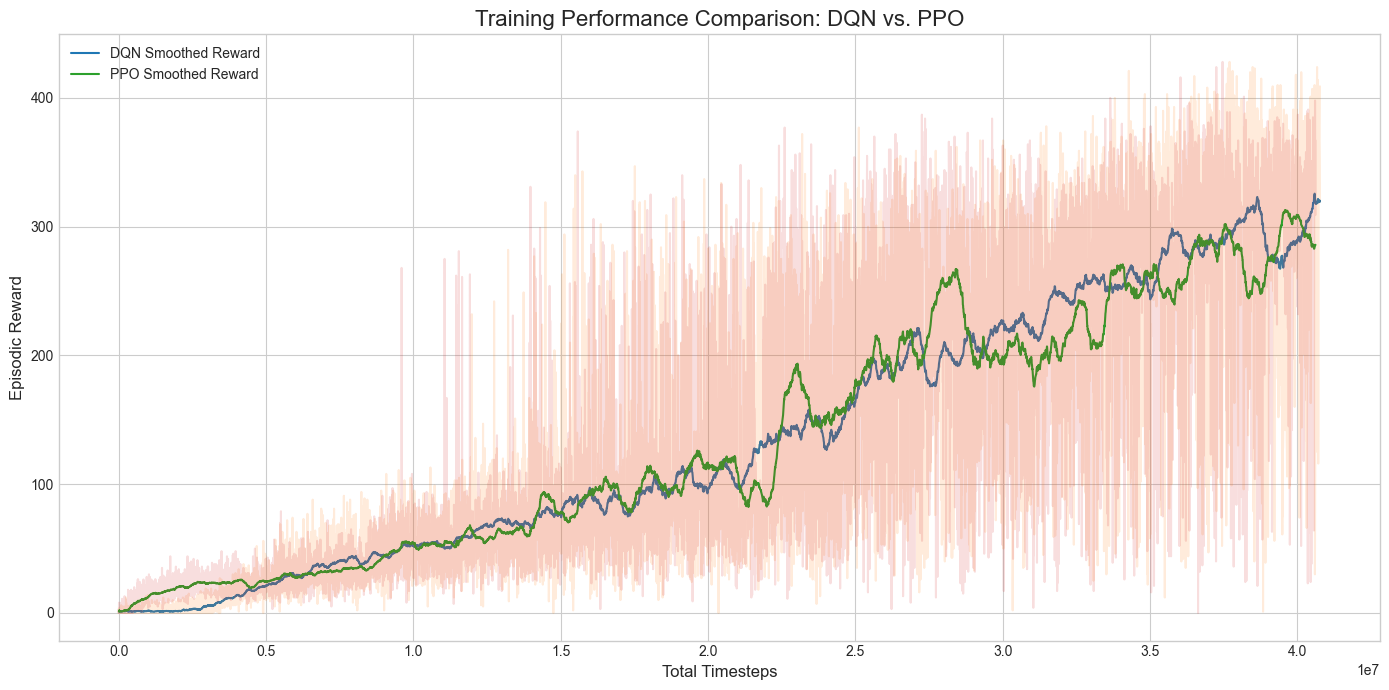

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy

def analyze_training_logs(log_folder: str, algorithm_name: str):
    """
    Loads training logs, calculates key performance metrics, and returns them.
    Handles both single and multiple monitor files automatically.

    :param log_folder: Path to the directory containing monitor.csv files.
    :param algorithm_name: The name of the algorithm (e.g., 'DQN', 'PPO').
    :return: A dictionary of metrics and the raw data for plotting.
    """
    print(f"Analyzing logs for {algorithm_name} in '{log_folder}'...")

    # Check if the log directory exists
    if not os.path.exists(log_folder):
        print(f"--> Error: Log folder not found at '{log_folder}'\n")
        return None, (None, None)

    try:
        # load_results automatically finds all *.monitor.csv files in the folder
        # ts2xy extracts the timesteps and rewards
        timesteps, rewards = ts2xy(load_results(log_folder), 'timesteps')
    except Exception as e:
        print(f"--> Error loading results for {algorithm_name}: {e}\n")
        return None, (None, None)

    # Check if any data was loaded
    if len(rewards) == 0:
        print(f"--> Warning: No reward data found in '{log_folder}'.\n")
        return None, (None, None)

    # --- Calculate Metrics ---
    total_episodes = len(rewards)
    total_timesteps = timesteps[-1]

    # Overall performance
    mean_reward_all = np.mean(rewards)
    std_reward_all = np.std(rewards)
    max_reward = np.max(rewards)

    # Final performance (more representative of the trained agent)
    # Use last 100 episodes, or all episodes if there are fewer than 100
    last_n = min(100, total_episodes)
    final_rewards = rewards[-last_n:]
    final_mean_reward = np.mean(final_rewards)
    final_std_reward = np.std(final_rewards)

    metrics = {
        "Algorithm": algorithm_name,
        "Total Episodes": f"{total_episodes:,}",
        "Total Timesteps": f"{total_timesteps:,}",
        "Mean Reward (All)": f"{mean_reward_all:.2f}",
        "Std Dev (All)": f"{std_reward_all:.2f}",
        "Max Reward": f"{max_reward:.2f}",
        f"Mean Reward (Last {last_n})": f"{final_mean_reward:.2f}",
        f"Std Dev (Last {last_n})": f"{final_std_reward:.2f}",
    }

    print(f"--> Analysis complete for {algorithm_name}.\n")
    return metrics, (timesteps, rewards)

# --- Main Execution ---

# Define the paths to your log directories
dqn_log_path = "./dqn/logs"
ppo_log_path = "./ppo/logs"

# Analyze both algorithms
dqn_metrics, dqn_data = analyze_training_logs(dqn_log_path, "DQN")
ppo_metrics, ppo_data = analyze_training_logs(ppo_log_path, "PPO")

# --- Display Results ---

# 1. Print a comparison table using pandas
all_metrics = []
if dqn_metrics:
    all_metrics.append(dqn_metrics)
if ppo_metrics:
    all_metrics.append(ppo_metrics)

if all_metrics:
    print("--- Performance Metrics Summary ---")
    df = pd.DataFrame(all_metrics).set_index("Algorithm")
    print(df.to_string()) # Use to_string() to prevent columns from being truncated
else:
    print("No data was found to generate a summary.")


# 2. Create a comparative plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for data, name in [(dqn_data, "DQN"), (ppo_data, "PPO")]:
    # --- THIS IS THE CORRECTED LINE ---
    timesteps, rewards = data

    if timesteps is not None and len(rewards) > 0:
        # Use a rolling average (smoothing) to see the trend more clearly
        # A window of 100 episodes is common for smoothing
        smoothed_rewards = pd.Series(rewards).rolling(100, min_periods=10).mean()

        # Plot the smoothed trend line
        ax.plot(timesteps, smoothed_rewards, label=f"{name} Smoothed Reward")
        # Plot the raw reward data with transparency
        ax.plot(timesteps, rewards, alpha=0.15)

ax.set_title("Training Performance Comparison: DQN vs. PPO", fontsize=16)
ax.set_xlabel("Total Timesteps", fontsize=12)
ax.set_ylabel("Episodic Reward", fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

In [5]:
df

,Total Episodes,Total Timesteps,Mean Reward (All),Std Dev (All),Max Reward,Mean Reward (Last 100),Std Dev (Last 100)
Algorithm,,,,,,,
DQN,"11,076","40,761,596",80.46,106.35,428.00,320.23,88.68
PPO,"8,977","40,610,211",106.44,108.47,428.00,285.94,92.30
